In [1]:
import pandas as pd



In [2]:
import numpy as np
import matplotlib.pyplot  as plt

In [3]:
df=pd.read_csv('../data/highly_relevant_posts_descending_threshold_50.csv')

In [4]:
df.drop(['subreddit','created_utc','over_18'], axis=1)

,title,selftext,date_created,combined_text,processed_text,relevance_probability
0,"Informal survey: What (legal) drugs, if any, '...","hi! so i'm officially diagnosed, tried dbt but...",2020-10-17 16:53:14,"Informal survey: What (legal) drugs, if any, '...",informal survey legal drug worked hi im offici...,1.000000
1,What combination of meds finally worked for yo...,right now i’m on:\nprozac 40mg\nwellbutrin xl ...,2020-06-25 14:47:27,What combination of meds finally worked for yo...,combination med finally worked hasn’t worked r...,1.000000
2,Does anyone have any experience(s) with any an...,"i abused benzodiazepines, so i cannot trust my...",2015-10-12 02:36:25,Does anyone have any experience(s) with any an...,anyone experience anxiolytic medicine besides ...,1.000000
3,My experience with lamictal/lamotrigine,this is going to be a very long post because i...,2021-08-12 14:13:55,My experience with lamictal/lamotrigine this i...,experience lamictallamotrigine going long post...,1.000000
4,How did antidepressants modify your behavior a...,"hello, i'd like to know :\n\n1) if you've been...",2020-01-31 18:47:16,How did antidepressants modify your behavior a...,antidepressant modify behavior cognition hello...,1.000000
...,...,...,...,...,...,...
2551,Meds seem to not be working.,i keep adding another flare but when i post an...,2021-09-13 22:10:20,Meds seem to not be working. i keep adding ano...,med seem working keep adding another flare pos...,0.500361
2552,Do you ever feel like your medication is actua...,i've been on lamotrigine for 7 months now. i w...,2020-05-08 03:11:07,Do you ever feel like your medication is actua...,ever feel like medication actually making feel...,0.500314
2553,Meds question,hi i was just wondering is anyone on mood stab...,2019-01-14 13:16:56,Meds question hi i was just wondering is anyon...,med question hi wondering anyone mood stabiliz...,0.500182
2554,"I feel much happier, but also far more depress...",i started dating my first boyfriend a couple m...,2021-01-08 05:41:46,"I feel much happier, but also far more depress...",feel much happier also far depressed boyfriend...,0.500148


In [5]:
from drug_named_entity_recognition import find_drugs

[({'name': 'Acetaminophen', 'synonyms': {'Acetominophen', 'Acetaco', 'Acetamidophenol', 'Acephen', 'Acamol', 'Tylenol', 'Actamin', 'Acetaminophen', 'Paracetamol', 'Paracetamolum', 'Datril', 'Hydroxyacetanilide', 'Panadol', 'Acenol', 'Ofirmev', 'Algotropyl'}, 'medline_plus_id': 'a621016', 'generic_names': ['Acetaminophen'], 'mesh_id': 'D058633', 'drugbank_id': 'DB00316', 'wikipedia_url': 'https://en.wikipedia.org/wiki/Paracetamol'}, 2, 2)]


In [6]:
def get_drug_list(text):
    drug_tuples = find_drugs(text.split(" "), is_ignore_case=True)
    drug_names = [drug[0] for drug in drug_tuples]
    drug_list= [drug.get('name') for drug in drug_names]
    unique_drug_list = sorted(set(drug_list))
    return unique_drug_list

In [7]:
df['drug_list'] =df['processed_text'].apply(get_drug_list)

In [8]:
from collections import defaultdict


def build_medication_index(df, column_name):
    med_index = defaultdict(list)
    for idx, row in df.iterrows():
        for med in row[column_name]:
            med_index[med].append(idx)
    return med_index

def find_medication_with_index(med_index, df, medication_name):
    if medication_name in med_index:
        matching_indices = med_index[medication_name]
        return df.loc[matching_indices]
    else:
        return pd.DataFrame()  # Return empty DataFrame if medication not found

# Build the index
med_index = build_medication_index(df, 'drug_list')



In [9]:
def get_synonyms(medication):
    drug_tuples = find_drugs(medication.split(" "), is_ignore_case=True)
    drug_names = [drug[0] for drug in drug_tuples]
    drug_list= [drug.get('synonyms') for drug in drug_names]
    return drug_list

In [10]:
def synonym_list_string(medication):
    return str(get_synonyms(medication_name)).strip('[,],{,}')

#### Wordclouds

I'm going to leave the WordCloud code in, because I think generating a word cloud of the sentiment analysis is going to give some pretty striking images.

The most frequently discussed medication is: Lamotrigine


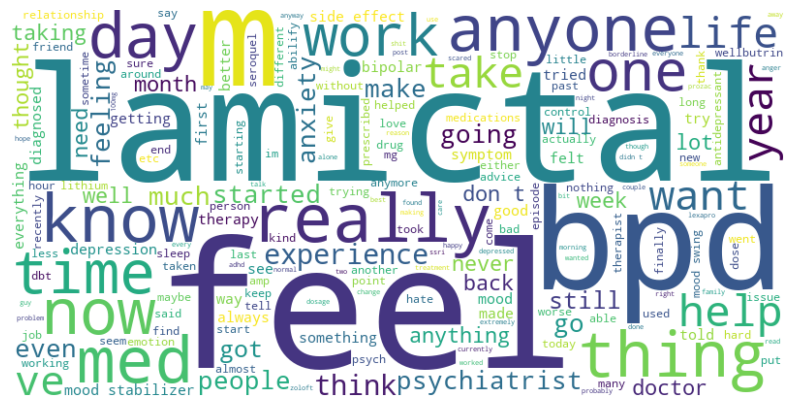

In [46]:
from wordcloud import WordCloud, STOPWORDS



# Find the most frequently discussed medication
drug_frequencies = df['drug_list'].explode().value_counts()
most_frequent_medication = drug_frequencies.idxmax()

print(f"The most frequently discussed medication is: {most_frequent_medication}")

# Filter rows containing the most frequently discussed medication
filtered_df = df[df['drug_list'].apply(lambda x: most_frequent_medication in x)]

# Combine the 'combined_text' of those rows
combined_text = " ".join(filtered_df['combined_text'])

# Define additional stopwords if needed
stopwords = set(STOPWORDS)
additional_stopwords = {"medication", "passage","lamotrigine","s","fucking"}  # Adding custom stopwords. The last one here is to remove profanity from the cloud
stopwords.update(additional_stopwords)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(combined_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title(f"Word Cloud for {most_frequent_medication}", fontsize=20)
plt.show()

wordcloud.to_file('Lamotrigine_words.png')

#### OpenAI sentiment analysis

We can also run sentiment analysis. Let's first figure out how large things are if we try to run sentiment analysis for Lamotrigine. Basically, this tells us how expensive it will be.

In [12]:
import tiktoken

combined_text = ' '.join(df["combined_text"])

# Initialize the encoder
enc = tiktoken.encoding_for_model("gpt-3.5")

# Count the tokens
num_tokens = len(enc.encode(combined_text))
print(f"Number of tokens: {num_tokens}")

Number of tokens: 1072666


So it will be roughly 5 dollars to run this through the entire data set. Let's determine the rough cost for running it for 'Lamotrigine'

In [13]:
df_Lamotrigine=df[df['drug_list'].apply(lambda x: 'Lamotrigine' in x)]
combined_text_Lamotrigine = ' '.join(df_Lamotrigine["combined_text"])
num_tokens = len(enc.encode(combined_text_Lamotrigine))
print(f"Number of tokens: {num_tokens}")

Number of tokens: 178756


In [40]:
import openai
import os

# Set your OpenAI API key
# You will need to replace this with your key if you want to run this model
api_key = 'Your API Key' 

# Check if the API key is available
if api_key is None:
    raise ValueError("API key is not set. Please set the OPENAI_API_KEY environment variable.")

openai.api_key = api_key

# Define a function to generate a response using GPT-3.5
def generate_response(prompt):
    try:
        response = openai.completions.create(
            model="gpt-3.5-turbo-instruct",  # Use appropriate engine
            prompt=prompt,
            max_tokens=150,
            n=1,
            stop=None,
            temperature=0.3,
        )
        return response.choices[0].text.strip()
    except Exception as e:
        print(f"Error generating response: {e}")
        return None

if __name__ == "__main__":
    # Example prompt
    prompt = "Tell me a joke."

    # Generate and print the response
    response = generate_response(prompt)
    if response:
        print("Generated Response:\n", response)
    else:
        print("Failed to generate response.")


Error generating response: Error code: 401 - {'error': {'message': 'Incorrect API key provided: Your API Key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Failed to generate response.


The joke that I got was "Why can't a bicycle stand? Because it was two-tired." However, to get a working response you will need to have an OpenAI API key.

In [17]:
# I need this snippet to determine how many tokens to use

# Calculate the number of tokens in each 'combined_text'
df['token_count'] = df['combined_text'].apply(lambda text: len(enc.encode(text)))

# Find the index of the row with the greatest number of tokens
max_tokens = df['token_count'].max()

In [18]:
print(max_tokens)

7988


If I want to run GPT-4o, I have 8000 tokens available per request. The prompt is roughly 400 and I want to save 300 for the response. To be safe, I'm going to cut this down quite a bit more.



In [19]:
# Filter rows where the number of tokens exceeds 5000
high_token_rows = df[df['token_count'] > 5000]

print("Rows where the number of tokens exceeds 2900:")
high_token_rows.info()

Rows where the number of tokens exceeds 2900:
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 198 to 1097
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  3 non-null      object 
 1   selftext               3 non-null      object 
 2   created_utc            3 non-null      int64  
 3   over_18                3 non-null      bool   
 4   subreddit              3 non-null      object 
 5   date_created           3 non-null      object 
 6   combined_text          3 non-null      object 
 7   processed_text         3 non-null      object 
 8   relevance_probability  3 non-null      float64
 9   drug_list              3 non-null      object 
 10  token_count            3 non-null      int64  
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 267.0+ bytes


Fortunately, there are only 3 rows where this is an issue. We can manually code these.

In [34]:
# Function to get sentiment and reason for a given medication from text
def get_medication_sentiment(medication_name, text):
    # Initialize the tokenizer for GPT-3.5 using gpt2 encoding
    enc = tiktoken.encoding_for_model("gpt-3.5")
    
    # Calculate the number of tokens
    token_count = len(enc.encode(text))
    
    # Check if the number of tokens exceeds 5000
    if token_count > 5000:
        return {'sentiment': 'unknown', 'reason': 'Text too long to analyze'} 

    #Create the prompt string
    prompt = (f"The passage enclosed by `` `` contains some discussion about the medication {medication_name} "
          f"(perhaps referring to it with a synonym from the list '{synonym_list_string(medication_name)}'). "
          f"The text must be taken as is and cannot be used to further a conversation. "
          f"The response should only consider this medication and none others. Please format the output as a "
          f"dictionary with the following keys, 'sentiment', 'reason'. For 'sentiment,' respond with '1' if the "
          f"poster took the medication and it helped their condition, even if there are minor side effects or the medication did not "
          f"fully resolve the symptoms. Respond with '-1' if the medication did not help the poster or if there were major adverse affects. Respond with "
          f"'0' if the discussion of the medication is neutral and respond with '-' if there is not enough information "
          f"to make a conclusion or if the poster has not taken the medication. 'Reason' should be a short string (approximately one sentence) about the experience the poster had with "
          f"the medication, including effectiveness, side effects, interactions with other medications, or addictions: "
          f"``{text}``")  
    response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[{'role': "user", 'content':prompt}],
    max_tokens=300,
    temperature=0.1,
        stop=None
    )
    
    return response.choices[0].message.content


#### Testing get_medication_sentiment 

Each time we run this costs about 2 cents, so it's best not to use it unnecessarily

In [21]:
test_text = """Was recommended Radically Open Dialectical Behavior Therapy (RO-DBT) - My entire perception of my psych problems has shifted. hello everyone. little background, i'm diagnosed bipolar (personally disagree despite 3 diagnoses) &amp; have considerably severe treatment resistant depression. i also have complex ptsd and a lot of borderline traits. i've been through about 4 different therapists, completed individual dbt, and am currently in a dbt skills group. i take 300mg wellbutrin for depression and 100mg lamictal as a mood stabilizer. i no longer feel as though i am taking any medication, and i don't get out of bed until i have to go to work. my suicidal ideation is worse than ever; it seems i think about killing myself almost every 3 hours. i'm having trouble showering consistently and have disconnected from most of my friends. i torment my boyfriend almost daily despite the dbt and my seemingly constant consumption of buddhist/shambhalic texts.


needless to say, i'm afraid i'm running out of options.


i started seeing a new therapist at my dbt center this week who is trained in radically open dbt, or ro-dbt. ro-dbt has essentially the opposite goal of standard dbt, in that it encourages open emotional expression as opposed to emotion regulation, and is for "overcontrolled" people (cluster c - avoidant, ocd) instead of "undercontrolled" (b - bpd, narcissistic, etc.). because i have extreme bouts of anger to the point of screaming and breaking things, it's pretty needless to say that i've never considered this kind of therapy.


initially they thought that prolonged exposure therapy for trauma would be best, as i felt my reactions to my environment stemmed from my childhood trauma (neglect, addict parents, etc.). however, during my first session, the therapist was extremely interested in what my reactions were in response to rather than the reactions themselves. she asked me about how i can't focus when the dog makes mouth sounds, how i can't let it go if my boyfriend leaves his guitars in the center of the room, and how i can't get anything accomplished because i get so distracted by details - i.e. going to take a shower and spending 20 minutes making a "shower playlist" to hear the perfect songs. 


hello everyone. little background, i'm diagnosed with bipolar 2 (personally disagree that i have bipolar at all despite 3 diagnoses) &amp; have considerably severe treatment resistant depression. i also have complex ptsd and a lot of borderline traits. i've been through about 4 different therapists, completed individual dbt, and am currently in a dbt skills group. i take 300mg wellbutrin for depression and 100mg lamictal as a mood stabilizer. i no longer feel as though i am taking any medication, and i don't get out of bed until i have to go to work. my suicidal ideation is worse than ever; it seems i think about killing myself almost every 3 hours. i'm having trouble showering consistently and have disconnected from most of my friends. i torment my boyfriend almost daily despite the dbt and my seemingly constant consumption of buddhist/shambhalic texts.


needless to say, i'm afraid i'm running out of options.


this week i started seeing a new therapist at my dbt center who is trained in radically open dbt, or ro-dbt. ro-dbt has essentially the opposite goal of standard dbt, in that its emphasis is on encouraging open emotional expression as opposed to emotion regulation, and is for "overcontrolled" people (cluster c - avoidant, ocd) instead of "undercontrolled" (b - bpd, narcissistic, etc.). because i have extreme bouts of anger to the point of screaming and breaking things, it's pretty needless to say that i've never considered this kind of therapy.


initially they thought that prolonged exposure therapy for trauma would be best, as i felt my reactions to my environment stemmed from my childhood trauma (neglect, addict parents, etc.). however, during my first session, the therapist was extremely interested in what my reactions were in response to rather than the reactions themselves. she asked me about how i can't focus when the dog makes mouth sounds, how i can't let it go if my boyfriend leaves his guitars in the center of the room, and how i can't get anything accomplished because i get so distracted by details - i.e. going to take a shower and spending 20 minutes making a "shower playlist" to hear the perfect songs. she was especially interested in the fact that none of my friends seem to believe i have mental health problems, because aside from lapses in my social involvement, i seem fine when i’m actually around everyone, despite my many explanations and admissions of my struggles at home. i only explode around my boyfriend, never at work, never at school, never with anyone other than him and every other boyfriend. i considered this a borderline trait, but she seemed extremely surprised that i can go from a huge fight, screaming and crying, then appear at work 15 minutes later and be able to chit chat with co-workers, despite secretly wanting to die. this is generally my life, i feel very uncomfortable and different, but i’m good at being funny, talking expressively, and making self-deprecating jokes.


i know i'm uptight and can be a perfectionist, however, i haven't completed my ba because i keep dropping out (due to depression), i do and have done a lot of drugs, i drink a lot, am and have always been promiscuous and generally impulsive. perfectionists are successful, right? i'm a broke waitress. i can't even get out of bed. i give up on everything i begin. i'm also a compulsive oversharer, it's a joke among my co-workers and people that know me that i would read everyone my diary if i had the chance. i connect with people all the time. 


then the therapist asked me, “how do you feel when you’re telling people these personal things? do you feel closer to them? do you feel connected to them?” 
i realized i don’t. 


i still feel very far away from people despite my frantic attempts at intimacy. i tell them all about myself but i’ll laugh or smile when talking about childhood trauma or sexual assault. she explained that you can share without connecting, especially when your emotional expression doesn’t fit the words. i’m saying vulnerable things because i’m terrified of actually being vulnerable. this is why i drink so much socially, and why i will do drugs socially. which even so, i’ve been told i’m a reserved drunk, and that i’m a serious person albeit a very funny one. i am constantly aware of my appearance and generally find myself unattractive despite being told i’m beautiful and getting considerable attention for my appearance throughout my adult life. i’ve had an on-again-off-again eating disorder for over 10 years and a relentless preoccupation with my weight despite being .1 above the underweight bmi. i won’t try new things around people, i never feel like i let loose. if one thing goes wrong i abandon a project. i was once asked to do vocals for a band and had to drink vodka beforehand and would still be singing too quietly, i was terrified and frozen. i refuse to practice anything around anyone.



she suggested that my depression and mood disorder could possibly stem from being overly controlled, that because i can’t let loose and i feel like things absolutely have to be a certain way, i paralyze myself and can’t progress. she suggested that this is why i haven’t pursued a career and why i have never shared my creative writing. on a lighter note, that this is why i refuse to do karaoke. 


she also suggested that the reason i explode on my boyfriend, and those in the past, is because they are the ones to actually see me vulnerable. i no longer have total control over my living environment. he see me in my pajamas on the couch at noon. he sees me sleep past 1. i can’t posture myself around him. so i am scared and i resent him. he’s going to leave me because he knows what i’m actually like. 


i spent the rest of the day in shock. i’m still processing it, which is partially why i wrote this. i’m starting ro-dbt next week. 



**has anyone here done ro-dbt before?** what can i expect?"""

In [22]:
medication_name = 'Lamotrigine'

In [24]:
prompt_test = (f"The passage enclosed by `` `` contains some discussion about the medication {medication_name} "
          f"(perhaps referring to it with a synonym from the list '{synonym_list_string(medication_name)}'). "
          f"The text must be taken as is and cannot be used to further a conversation. "
          f"The response should only consider this medication and none others. Please format the output as a "
          f"dictionary with the following keys, 'sentiment', 'reason'. For 'sentiment,' respond with '1' if the "
          f"poster took the medication and it helped their condition, even if there are minor side effects or the medication did not "
          f"fully resolve the symptoms. Respond with '-1' if the medication did not help the poster or if there were major adverse affects. Respond with "
          f"'0' if the discussion of the medication is neutral and respond with '-' if there is not enough information "
          f"to make a conclusion or if the poster has not taken the medication. 'Reason' should be a short string (approximately one sentence) about the experience the poster had with "
          f"the medication, including effectiveness, side effects, interactions with other medications, or addictions: "
          f"``{test_text}``")

In [25]:
print(prompt_test)

The passage enclosed by `` `` contains some discussion about the medication Lamotrigine (perhaps referring to it with a synonym from the list ''Labileno', 'Lamotrigine', 'Crisomet', 'Lamiktal', 'Lamotrigina', 'Lamictal', 'Lamotriginum''). The text must be taken as is and cannot be used to further a conversation. The response should only consider this medication and none others. Please format the output as a dictionary with the following keys, 'sentiment', 'reason'. For 'sentiment,' respond with '1' if the poster took the medication and it helped their condition, even if there are minor side effects or the medication did not fully resolve the symptoms. Respond with '-1' if the medication did not help the poster or if there were major adverse affects. Respond with '0' if the discussion of the medication is neutral and respond with '-' if there is not enough information to make a conclusion or if the poster has not taken the medication. 'Reason' should be a short string (approximately one

In [26]:
#This is the part that actually costs money, so I'm going to comment it out so that it can't be run extra times accidentally

# test_response = openai.chat.completions.create(
#     model="gpt-4o",
#     messages=[{'role': "user", 'content':prompt_test}],
#     max_tokens=300,
#     temperature=0.1,
#         stop=None
#     )

In [27]:
test_response

ChatCompletion(id='chatcmpl-9UZxQ1sbmXkRk83zGjwEdMM0OI4Lc', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{\n  "sentiment": "-1",\n  "reason": "The poster reports that despite taking 100mg Lamictal as a mood stabilizer, their condition has not improved and their suicidal ideation is worse than ever."\n}\n```', role='assistant', function_call=None, tool_calls=None))], created=1717075088, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_43dfabdef1', usage=CompletionUsage(completion_tokens=52, prompt_tokens=1988, total_tokens=2040))

In [29]:
test_response.choices[0].message.content

'```json\n{\n  "sentiment": "-1",\n  "reason": "The poster reports that despite taking 100mg Lamictal as a mood stabilizer, their condition has not improved and their suicidal ideation is worse than ever."\n}\n```'

In [31]:
# Function to analyze sentiment for a specified medication
def analyze_medication_sentiment(df, medication_name):
    # Apply the get_medication_sentiment function to each row in the DataFrame
    df[f'reponse_{medication_name}'] = df['combined_text'].apply(lambda text: get_medication_sentiment(text, medication_name))
    return df


In [32]:
df_Lamotrigine.head()

,title,selftext,created_utc,over_18,subreddit,date_created,combined_text,processed_text,relevance_probability,drug_list
0,"Informal survey: What (legal) drugs, if any, '...","hi! so i'm officially diagnosed, tried dbt but...",1602953594,False,BPD,2020-10-17 16:53:14,"Informal survey: What (legal) drugs, if any, '...",informal survey legal drug worked hi im offici...,1.000000,"[Alprazolam, Amitriptyline, Aripiprazole, Cita..."
3,My experience with lamictal/lamotrigine,this is going to be a very long post because i...,1628777635,False,BPD,2021-08-12 14:13:55,My experience with lamictal/lamotrigine this i...,experience lamictallamotrigine going long post...,1.000000,"[Alprazolam, Bupropion, Buspirone, Clonazepam,..."
8,What medication(s) work best for when you have...,i am formally diagnosed with severe general an...,1618869415,False,BPD,2021-04-19 21:56:55,What medication(s) work best for when you have...,medication work best several mental illness in...,0.999999,"[Amphetamine, Aripiprazole, Bupropion, Citalop..."
12,My first time Inpatient: how I learned to advo...,"hi everyone, i just got released from the hosp...",1594470067,False,BPD,2020-07-11 12:21:07,My first time Inpatient: how I learned to advo...,first time inpatient learned advocate hi every...,0.999997,"[Fluoxetine, Lamotrigine]"
14,Tomorrow I am seeing my doctor pertaining to m...,"okay, i just need to get this out. \n\nso afte...",1451986895,False,BPD,2016-01-05 09:41:35,Tomorrow I am seeing my doctor pertaining to m...,tomorrow seeing doctor pertaining medication i...,0.999996,"[Aripiprazole, Lamotrigine, Topiramate]"


In [35]:
# Running ChatGPT on a test collection of posts to see if this works
#### WARNING: THIS COSTS ABOUT .10 TO RUN. USE JUDICIOUSLY. 
#The line calling the API has been commented out, to avoid unnecessary costs

df_Lamotrigine_20 = df_Lamotrigine.head(20)

medication_name = 'Lamotrigine'
# Using the evaluation function for sentiment
#results_df = analyze_medication_sentiment(df_Lamotrigine_20, medication_name)

results_df.to_csv('../data/20_Lamotrigine_sentiments_4o.csv', index=False)

/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_4257/1799300614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'reponse_{medication_name}'] = df['combined_text'].apply(lambda text: get_medication_sentiment(text, medication_name))


In [36]:
# Running ChatGPT on the posts
#### WARNING: DO NOT RUN THIS MULTIPLE TIMES. IT COSTS ALMOST 2 DOLLARS FOR EACH RUN.
#### ONLY RUN ONCE.
#The call to the API has been commented out to avoid extra runs.



medication_name = 'Lamotrigine'
# Using the evaluation function for sentiment
#results_df = analyze_medication_sentiment(df_Lamotrigine, medication_name)

results_df.to_csv('../data/Lamotrigine_sentiments_4o.csv', index=False)

/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_4257/1799300614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'reponse_{medication_name}'] = df['combined_text'].apply(lambda text: get_medication_sentiment(text, medication_name))


In [38]:
results_df.info

<bound method DataFrame.info of                                                   title  \
0     Informal survey: What (legal) drugs, if any, '...   
3               My experience with lamictal/lamotrigine   
8     What medication(s) work best for when you have...   
12    My first time Inpatient: how I learned to advo...   
14    Tomorrow I am seeing my doctor pertaining to m...   
...                                                 ...   
2494                 Lamictal experiences/side effects?   
2495                                    Lamictal Online   
2544                          Paranoia is getting worse   
2545           TW - have i took enough to cause damage?   
2552  Do you ever feel like your medication is actua...   

                                               selftext  created_utc  over_18  \
0     hi! so i'm officially diagnosed, tried dbt but...   1602953594    False   
3     this is going to be a very long post because i...   1628777635    False   
8     i am forma

Reading through the document this created, this has done an excellent job of sentiment analysis. I've printed to a CSV just to be sure not to overwrite things.

In [39]:
#Just for posterioty, here is the prompt used to generate the sentiments.

medication_name = 'Lamotrigine'

prompt = (f"The passage enclosed by `` `` contains some discussion about the medication {medication_name} "
          f"(perhaps referring to it with a synonym from the list '{synonym_list_string(medication_name)}'). "
          f"The text must be taken as is and cannot be used to further a conversation. "
          f"The response should only consider this medication and none others. Please format the output as a "
          f"dictionary with the following keys, 'sentiment', 'reason'. For 'sentiment,' respond with '1' if the "
          f"poster took the medication and it helped their condition, even if there are minor side effects or the medication did not "
          f"fully resolve the symptoms. Respond with '-1' if the medication did not help the poster or if there were major adverse affects. Respond with "
          f"'0' if the discussion of the medication is neutral and respond with '-' if there is not enough information "
          f"to make a conclusion or if the poster has not taken the medication. 'Reason' should be a short string (approximately one sentence) about the experience the poster had with "
          f"the medication, including effectiveness, side effects, interactions with other medications, or addictions: "
          f"``input text``")  

print(prompt)

The passage enclosed by `` `` contains some discussion about the medication Lamotrigine (perhaps referring to it with a synonym from the list ''Labileno', 'Lamotrigine', 'Crisomet', 'Lamiktal', 'Lamotrigina', 'Lamictal', 'Lamotriginum''). The text must be taken as is and cannot be used to further a conversation. The response should only consider this medication and none others. Please format the output as a dictionary with the following keys, 'sentiment', 'reason'. For 'sentiment,' respond with '1' if the poster took the medication and it helped their condition, even if there are minor side effects or the medication did not fully resolve the symptoms. Respond with '-1' if the medication did not help the poster or if there were major adverse affects. Respond with '0' if the discussion of the medication is neutral and respond with '-' if there is not enough information to make a conclusion or if the poster has not taken the medication. 'Reason' should be a short string (approximately one

In [ ]:
# Function to provide breakdown of sentiment for a medication
def sentiment_breakdown(df, sentiment_col_name):
    numeric_sentiments = df[sentiment_col_name].loc[df[sentiment_col_name].astype(str).str.isnumeric()].astype(int)
    sentiment_counts = numeric_sentiments.value_counts()
    total = len(df)  # Total number of sentiments, including non-numeric
    breakdown = {}
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total) * 100
        breakdown[str(sentiment)] = {'count': count, 'percentage': percentage}
    
    non_numeric_sentiments = df[sentiment_col_name].loc[~df[sentiment_col_name].astype(str).str.isnumeric()]
    for sentiment in non_numeric_sentiments.unique():
        count = non_numeric_sentiments.eq(sentiment).sum()
        percentage = (count / total) * 100
        breakdown[sentiment] = {'count': count, 'percentage': percentage}
    
    return breakdown

# Function to plot histogram of sentiment counts
def plot_sentiment_histogram(df, sentiment_col_name):
    sentiment_counts = df[sentiment_col_name].value_counts()
    plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Histogram of Sentiment Counts')
    plt.show()
